<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/hmm_poisson_changepoint_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM with Poisson observations for detecting changepoints in the rate of a signal

Code is from
https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection


In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

# Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.


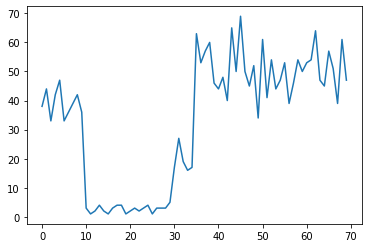

In [2]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

np.random.seed(42)

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

# Model with fixed $K$

To model the changing Poisson rate, we use an HMM.
We initially assume the number of states is known to be $K=4$.
Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform,
and fix the transition matrix to be the following, where we set $p=0.05$:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$


In [4]:
num_states = 4

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scale).

In [35]:
# Define variable to represent the unknown log rates.

np.random.seed(1)

trainable_log_rates = tf.Variable(
  np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

# Model fitting using gradient descent.

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

In [36]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

In [37]:
for step in range(201):
  loss, rates = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, -loss, rates))

print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

step 0: log prob -439.37994384765625 rates [43.770798 23.930693 13.291853 19.616514]
step 20: log prob -253.2379150390625 rates [50.375736  17.853971   2.8620021 19.08064  ]
step 40: log prob -251.63722229003906 rates [47.57612   19.170776   2.1243722 18.768087 ]
step 60: log prob -250.3348846435547 rates [48.521667 18.814938  2.540438 18.834839]
step 80: log prob -250.27603149414062 rates [48.16269   18.790636   2.7347238 18.842407 ]
step 100: log prob -250.2480926513672 rates [48.259808  18.815382   2.6603415 18.831062 ]
step 120: log prob -250.24813842773438 rates [48.277992  18.827494   2.6479864 18.829464 ]
step 140: log prob -250.2478790283203 rates [48.27264  18.832064  2.66061  18.83017 ]
step 160: log prob -250.2478485107422 rates [48.269577  18.831314   2.6579792 18.830757 ]
step 180: log prob -250.24769592285156 rates [48.268345  18.830502   2.6574643 18.830853 ]
step 200: log prob -250.24769592285156 rates [48.267876  18.83087    2.6580043 18.83078  ]
Inferred rates: [48.26

We see that the method learned a good approximation to the true (generating) parameters, up to a permutation of the states (since the labels are unidentifiable). However, results can vary with different random seeds. We may find that   the rates are the same for some states, which means those states are  being treated as identical, and are therefore redundant.

# Plotting the posterior  over states

In [38]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

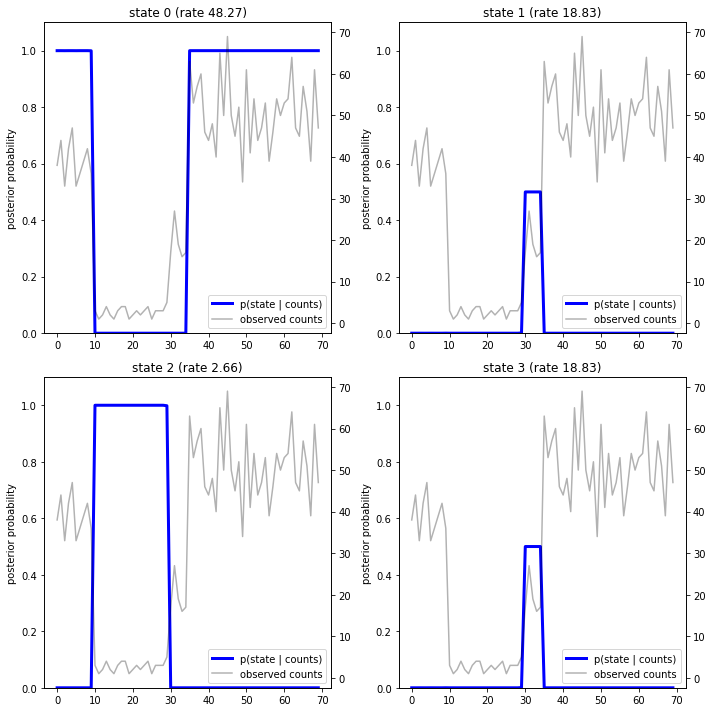

In [39]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

In [40]:
# max marginals
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_rates = rates[most_probable_states]

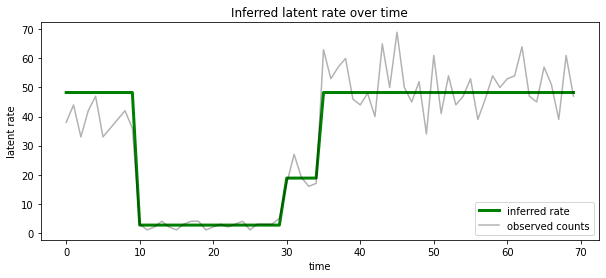

In [41]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

In [42]:
# max probaility trajectory (Viterbi)
most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = rates[most_probable_states]

Text(0.5, 1.0, 'Inferred latent rate over time')

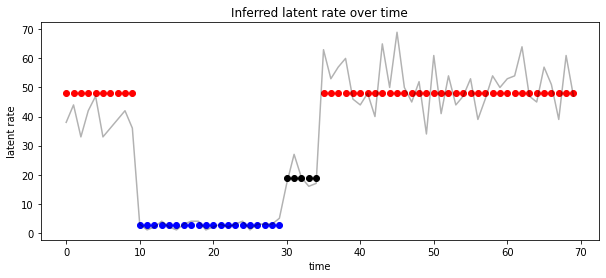

In [43]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = np.array(['r', 'g', 'b', 'k'])
colors = color_list[most_probable_states]
for i in range(len(colors)):
  ax.plot(i, most_probable_rates[i], '-o', c=colors[i], lw=3)
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")

# Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximuze over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$


We can do this by fitting a bank of separate HMMs in parallel, one for each value of $K$. We need to make them all the same size so we can batch them efficiently. To do this, we pad the transition matrices (and other paraemeter vectors) so they all have the same shape, and then use masking.

In [44]:
max_num_states = 6

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


In [45]:
np.random.seed(1)

trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
     name='log_rates')
    
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

In [46]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

# Model fitting with gradient descent

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

for step in range(201):
  loss, rates =  [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: loss {}".format(step, loss))

step 0: loss [1063.3252   549.5645   558.07043  473.30814  480.6603   486.91394]
step 20: loss [855.18536 292.3078  267.15866 243.97485 250.30139 255.54227]
step 40: loss [847.0159  286.18994 244.30667 240.50877 246.94565 251.14537]
step 60: loss [845.76294 285.33478 244.22743 239.95215 246.37498 249.98888]
step 80: loss [845.70514 285.35037 244.00246 239.62125 246.04858 248.75699]
step 100: loss [845.69293 285.33423 243.95595 239.62405 246.05049 247.8394 ]
step 120: loss [845.6929  285.33298 243.9542  239.61908 246.04538 246.98442]
step 140: loss [845.6924  285.333   243.95293 239.61916 246.04547 246.21884]
step 160: loss [845.69275 285.33307 243.95271 239.61916 246.04532 245.54015]
step 180: loss [845.69244 285.33298 243.95288 239.61888 246.04535 244.94615]
step 200: loss [845.6928  285.33298 243.9529  239.61888 246.04543 244.43217]


# Plot marginal likelihood of each model

Text(0.5, 1.0, 'Model selection on latent states')

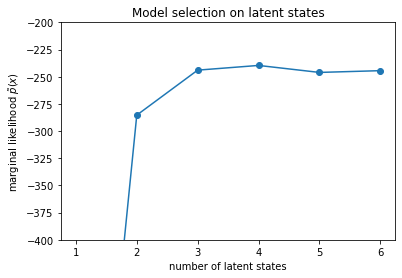

In [49]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss, 'o-')
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

# Plot posteriors

In [51]:
print(rates.shape)
print(rates)

(6, 6)
[[3.31720848e+01 5.45666695e+01 6.47975311e+01 1.85639362e+01
  5.99805222e+01 2.04151173e+01]
 [4.53633575e+01 2.66111779e+00 6.47975311e+01 1.85639362e+01
  5.99805222e+01 2.04151173e+01]
 [1.90151253e+01 2.65805936e+00 4.82678032e+01 1.85639362e+01
  5.99805222e+01 2.04151173e+01]
 [3.89240112e+01 1.90124340e+01 5.09194336e+01 2.65769815e+00
  5.99805222e+01 2.04151173e+01]
 [3.89220047e+01 1.90125790e+01 5.08898697e+01 2.65769672e+00
  5.08897972e+01 2.04151173e+01]
 [3.89172478e+01 1.90124340e+01 5.08882942e+01 2.65770102e+00
  5.08882561e+01 1.13236834e-04]]


In [50]:
posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

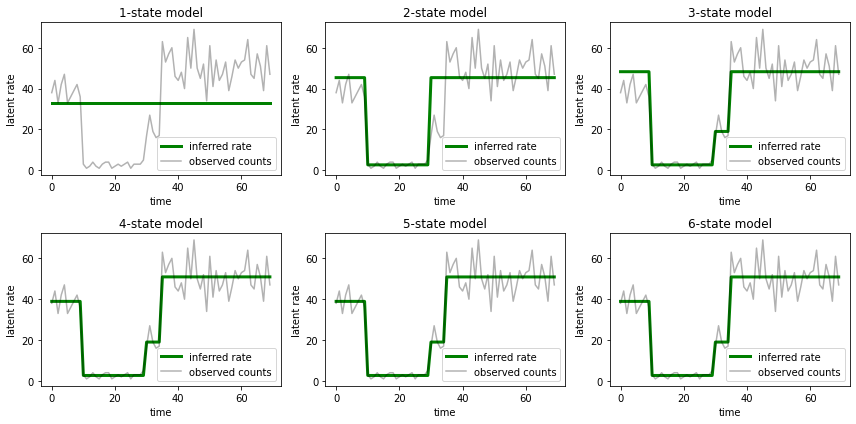

In [55]:
fig = plt.figure(figsize=(12, 6))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(2, 3, i+1)
  ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()